In [1]:
import torch
import w1d4_tests
import matplotlib.pyplot as plt

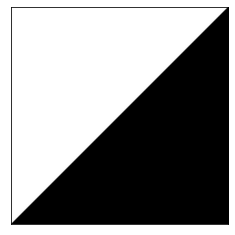

In [56]:
fname = "1d_conv.jpeg"
w1d4_tests.plot_image(fname)
fname = "cat.jpeg"
w1d4_tests.plot_image(fname)
fname = "hst-bw_orig.jpg"
w1d4_tests.plot_image(fname)



In [158]:
img = Image.open(fname)
tensorize = transforms.ToTensor()
img = tensorize(img)
print(img)


tensor([[[0.6431, 0.8431, 0.8157,  ..., 0.8549, 0.8118, 0.2392],
         [0.8157, 1.0000, 0.9882,  ..., 0.9765, 0.4784, 0.0000],
         [0.8078, 1.0000, 0.9765,  ..., 0.4510, 0.0000, 0.0000],
         ...,
         [0.8706, 0.9647, 0.4157,  ..., 0.0000, 0.0000, 0.0000],
         [0.7804, 0.4863, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.6431, 0.8431, 0.8157,  ..., 0.8549, 0.8118, 0.2392],
         [0.8157, 1.0000, 0.9882,  ..., 0.9765, 0.4784, 0.0000],
         [0.8078, 1.0000, 0.9765,  ..., 0.4510, 0.0000, 0.0000],
         ...,
         [0.8706, 0.9647, 0.4157,  ..., 0.0000, 0.0000, 0.0000],
         [0.7804, 0.4863, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.6431, 0.8431, 0.8157,  ..., 0.8549, 0.8118, 0.2392],
         [0.8157, 1.0000, 0.9882,  ..., 0.9765, 0.4784, 0.0000],
         [0.8078, 1.0000, 0.9765,  ..., 0.4510, 0.0000, 0.

In [57]:
from PIL import Image
img = Image.open(fname)
tensorize = transforms.ToTensor()
img = tensorize(img)
img = einops.rearrange(img, "c h w -> h w c")
height, width = img.shape[:2]
height, width

(800, 800)

In [58]:
data_train, data_test =  w1d4_tests.load_image(fname)

In [73]:
for x, y in data_train:
    print(x.shape)
    print(y.shape)
    print(y)
    break

torch.Size([128, 2])
torch.Size([128, 3])
tensor([[ 0.5000,  0.5000,  0.5000],
        [-0.5000, -0.5000, -0.5000],
        [ 0.5000,  0.5000,  0.5000],
        [ 0.5000,  0.5000,  0.5000],
        [-0.5000, -0.5000, -0.5000],
        [ 0.5000,  0.5000,  0.5000],
        [ 0.5000,  0.5000,  0.5000],
        [ 0.5000,  0.5000,  0.5000],
        [ 0.5000,  0.5000,  0.5000],
        [-0.5000, -0.5000, -0.5000],
        [ 0.5000,  0.5000,  0.5000],
        [ 0.5000,  0.5000,  0.5000],
        [ 0.4961,  0.4961,  0.4961],
        [ 0.5000,  0.5000,  0.5000],
        [ 0.5000,  0.5000,  0.5000],
        [ 0.5000,  0.5000,  0.5000],
        [-0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000],
        [ 0.5000,  0.5000,  0.5000],
        [ 0.5000,  0.5000,  0.5000],
        [ 0.5000,  0.5000,  0.5000],
        [ 0.5000,  0.5000,  0.5000],
        [-0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000],
        [ 0.5000,  0.5000,  0.5000],
        [ 0.5000,  0.5000,  0.500

In [4]:
torch.nn.Linear?

Init signature:
torch.nn.Linear(
    in_features: int,
    out_features: int,
    bias: bool = True,
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

Args:
    in_features: size of each input sample
    out_features: size of each output sample
    bias: If set to ``False``, the layer will not learn an additive bias.
        Default: ``True``

Shape:
    - Input: :math:`(*, H_{in})` where :math:`*` means any number of
      dimensions including none and :math:`H_{in} = \text{in\_features}`.
    - Output: :math:`(*, H_{out})` where all but the last dimension
      are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

Attributes:
    weight: the learnable weights of the module of shape
        :math:`(\text{out\_features}, \text{in\_features})`. The values are
        initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k}

In [6]:
torch.nn.ReLU?

Init signature: torch.nn.ReLU(inplace: bool = False)
Docstring:     
Applies the rectified linear unit function element-wise:

:math:`\text{ReLU}(x) = (x)^+ = \max(0, x)`

Args:
    inplace: can optionally do the operation in-place. Default: ``False``

Shape:
    - Input: :math:`(*)`, where :math:`*` means any number of dimensions.
    - Output: :math:`(*)`, same shape as the input.

.. image:: ../scripts/activation_images/ReLU.png

Examples::

    >>> m = nn.ReLU()
    >>> input = torch.randn(2)
    >>> output = m(input)


  An implementation of CReLU - https://arxiv.org/abs/1603.05201

    >>> m = nn.ReLU()
    >>> input = torch.randn(2).unsqueeze(0)
    >>> output = torch.cat((m(input),m(-input)))
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/.local/lib/python3.8/site-packages/torch/nn/modules/activation.py
Type:           type
Subclasses:     ReLU6


In [13]:
class ThreeLayerNN(torch.nn.Module):
    def __init__(self, P, H, K):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(P,H),
            torch.nn.ReLU(),
            torch.nn.Linear(H,H),
            torch.nn.ReLU(),
            torch.nn.Linear(H,K),
        )
    
    def forward(self,x):
        return self.layers(x)
    

In [14]:
# test
from w1d4_tests import test_mlp

test_mlp(ThreeLayerNN)


Congrats! You've passed the test.


In [17]:


def train(model, dataloader, lr, momentum):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = torch.nn.L1Loss()
    for input, target in dataloader:
        optimizer.zero_grad()	# sets param.grad to None for linked params
                        # (this prevents accumulation of gradients)
        output = model(input)		  # the model’s predictions
        loss = loss_fn(output, target)	  # measure how bad predictions are
        loss.backward()			  # calculate gradients
        optimizer.step()			  # use gradients to update params

    return model

In [18]:
# test
w1d4_tests.test_train(train)


Congrats! You've passed the test.


In [156]:
def evaluate(model, dataloader):
    model.eval()
    loss_fn = torch.nn.L1Loss(reduction = 'mean')
    overall_loss = 0
    num_batch = 0
    for input, target in dataloader:
        output = model(input)		  # the model’s predictions
        overall_loss += loss_fn(output, target)	  # measure how bad predictions are
        num_batch += 1
    
    return overall_loss/num_batch


In [157]:
from w1d4_tests import *

test_evaluate(evaluate)

Congrats! You've passed the test.


In [75]:
m = ThreeLayerNN(2,400,3)
lr = 0.01
momentum = 0.3
epochs = 10
training_loss = []
test_loss = []

def train_with_loss(model, data_train, data_test, lr, momentum):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = torch.nn.L1Loss()
    training_loss = []
    test_loss = []

    for input, target in data_train:
        optimizer.zero_grad()	# sets param.grad to None for linked params
                        # (this prevents accumulation of gradients)
        output = model(input)		  # the model’s predictions
        loss = loss_fn(output, target)	  # measure how bad predictions are
        loss.backward()			  # calculate gradients
        optimizer.step()			  # use gradients to update params

        training_loss.append(loss.detach())
        test_loss.append(evaluate(model, data_test).detach())
        model.train()

    return model, training_loss, test_loss

for i in range(epochs):
    m, epoch_training_loss, epoch_test_loss = train_with_loss(m, data_train, data_test, lr, momentum)
    training_loss.extend(epoch_training_loss)
    test_loss.extend(epoch_test_loss)


Text(0.5, 0, '# training steps')

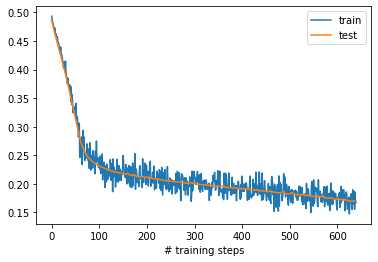

In [77]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.xlabel('# training steps')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
tensor(0.7039, grad_fn=<MaxBackward1>)
tensor(-0.7495, grad_fn=<MinBackward1>)


'\nThings that might have helped: momentum, loss.detach()\nCentering:\n- Why is it needed?\n- Done during training? We can force outputs to be within a certain range before comparing with the target to compute the loss\n'

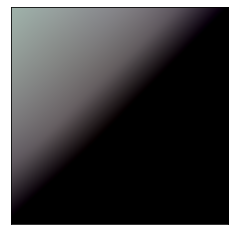

In [79]:
# height, width = (317, 574)
# Cat
# height, width = (576, 1024)
height, width = 800, 800

m.eval()

out = torch.zeros(height, width, 3)

for r in range(height):
    row_num = r*torch.ones((width,1))/height - 0.5
    col_num = torch.arange(width).unsqueeze(1)/width - 0.5
    row_inputs = torch.cat([row_num,col_num],dim = 1)
    out[r] = m(row_inputs)

print(torch.max(out))
print(torch.min(out))

# fig = plt.imshow((out.detach().numpy())+(581.5394+0.0124)/2)
fig = plt.imshow((out.detach().numpy()))
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
"""
Things that might have helped: momentum, loss.detach()
Centering:
- Why is it needed?
- Done during training? We can force outputs to be within a certain range before comparing with the target to compute the loss
"""


In [84]:
def f(x, y, a=1, b=100):
    return (a-x)**2 + b*(y-x**2)**2 + 1


torch.Size([100, 100])
torch.Size([100, 100])
(100, 100)


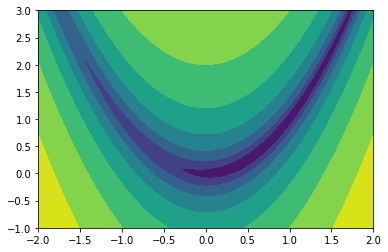

In [101]:
x = torch.linspace(-2.0, 2.0, 100)
y = torch.linspace(-1.0, 3.0, 100)

xy = torch.meshgrid(x,y)

print(f(*xy).shape)
print(xy[1].shape)

x = xy[0].numpy()
y = xy[1].numpy()

print(f(*xy).numpy().shape)
plt.contourf(x,y,torch.log(f(*xy)).numpy())


# print(xy)

In [103]:
torch.optim.SGD?


Init signature:
torch.optim.SGD(
    params,
    lr=<required parameter>,
    momentum=0,
    dampening=0,
    weight_decay=0,
    nesterov=False,
)
Docstring:     
Implements stochastic gradient descent (optionally with momentum).

.. math::
   \begin{aligned}
        &\rule{110mm}{0.4pt}                                                                 \\
        &\textbf{input}      : \gamma \text{ (lr)}, \: \theta_0 \text{ (params)}, \: f(\theta)
            \text{ (objective)}, \: \lambda \text{ (weight decay)},                          \\
        &\hspace{13mm} \:\mu \text{ (momentum)}, \:\tau \text{ (dampening)},\:nesterov\\[-1.ex]
        &\rule{110mm}{0.4pt}                                                                 \\
        &\textbf{for} \: t=1 \: \textbf{to} \: \ldots \: \textbf{do}                         \\
        &\hspace{5mm}g_t           \leftarrow   \nabla_{\theta} f_t (\theta_{t-1})           \\
        &\hspace{5mm}\textbf{if} \: \lambda \neq 0                 

In [115]:
xy = torch.tensor([-1.5, 2.5])

def opt_rosenbrock(xy, lr, momentum, n_iter):
    xy.requires_grad = True
    optimizer = torch.optim.SGD([xy], lr, momentum)
    xys = []

    for i in range(n_iter):
        xys.append(xy.detach() + 0)
        optimizer.zero_grad()
        loss = f(xy[0],xy[1])
        loss.backward()
        optimizer.step()
    xys.append(xy.detach())

    return torch.stack(xys, dim=0)


    
    
    
    


In [116]:
w1d4_tests.test_rosenbrock(opt_rosenbrock)


Testing configuration:  {'lr': 0.001, 'momentum': 0.0, 'n_iter': 10}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.001, 'momentum': 0.8, 'n_iter': 20}
Congrats! You've passed the test.


torch.Size([100, 100])
torch.Size([100, 100])
(100, 100)


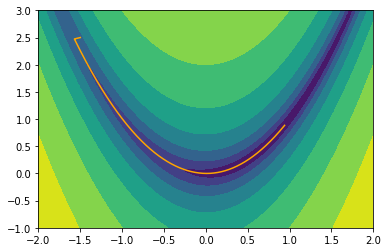

In [125]:
x = torch.linspace(-2.0, 2.0, 100)
y = torch.linspace(-1.0, 3.0, 100)

xy = torch.meshgrid(x,y)

print(f(*xy).shape)
print(xy[1].shape)

x = xy[0].numpy()
y = xy[1].numpy()

print(f(*xy).numpy().shape)
plt.contourf(x,y,torch.log(f(*xy)).numpy())
trajectory = opt_rosenbrock(torch.tensor([-1.5, 2.5]), lr=0.0003, momentum=0.0, n_iter=20000)
plt.plot(trajectory[:, 0], trajectory[:, 1], color='orange')

In [133]:
class SGD:
    def __init__(self, params, lr, momentum, dampening, weight_decay):
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.dampening = dampening
        self.weight_decay = weight_decay
        self.first_iter = True
        self.b = [0]*len(self.params)
    
    def zero_grad(self):
        for param in self.params:
            param.grad = None

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                gradient = param.grad

                # weight decay
                gradient += self.weight_decay*param
                
                # momentum
                if self.first_iter:
                    self.b[i] = gradient
                else:
                    self.b[i] = self.momentum*self.b[i] + (1-self.dampening)*gradient
                
                # assuming no Nesterov
                gradient = self.b[i]
                
                # vanilla SGD
                param -= self.lr*gradient

        self.first_iter = False


In [134]:
w1d4_tests.test_sgd(SGD)


Testing configuration:  {'lr': 0.1, 'momentum': 0.0, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.7, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'momentum': 0.8, 'dampening': 0.0, 'weight_decay': 0.05}
Congrats! You've passed the test.


In [139]:
class RMSprop:
    def __init__(self, params, lr, alpha, eps, weight_decay, momentum):
        self.params = list(params)
        self.lr = lr
        self.alpha = alpha
        self.epsilon = eps
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.b = [0]*len(self.params)
        self.v = [0]*len(self.params)
    
    def zero_grad(self):
        for param in self.params:
            param.grad = None

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                gradient = param.grad

                # weight decay
                gradient += self.weight_decay*param
                
                # alpha
                self.v[i] = self.alpha * self.v[i] + (1 - self.alpha) * gradient**2
                
                # assuming not centered
                
                # momentum
                if self.momentum > 0:
                    self.b[i] = self.momentum * self.b[i] + gradient / (torch.sqrt(self.v[i]) + self.epsilon)
                    param -= self.lr * self.b[i]
                else:
                    param -= self.lr * gradient / (torch.sqrt(self.v[i]) + self.epsilon)




In [140]:
w1d4_tests.test_rmsprop(RMSprop)


Testing configuration:  {'lr': 0.1, 'alpha': 0.9, 'eps': 0.001, 'weight_decay': 0.0, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.5}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.


In [141]:
class Adam:
    def __init__(self, params, lr, betas, eps, weight_decay):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.epsilon = eps
        self.weight_decay = weight_decay
        self.m = [0]*len(self.params)
        self.v = [0]*len(self.params)
        self.t = 1
    
    def zero_grad(self):
        for param in self.params:
            param.grad = None

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                gradient = param.grad

                # weight decay
                gradient += self.weight_decay*param
                
                # alpha
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * gradient
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * gradient**2

                m_hat = self.m[i] / (1 - self.beta1**self.t)
                v_hat = self.v[i] / (1 - self.beta2**self.t)
                
                # assuming no amsgrad

                param -= self.lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)

        self.t += 1


In [142]:
w1d4_tests.test_adam(Adam)


Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.95), 'eps': 0.001, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.9), 'eps': 0.001, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'betas': (0.9, 0.95), 'eps': 0.01, 'weight_decay': 0.08}
Congrats! You've passed the test.


In [153]:

def opt_rosenbrock_compare_optimizers(xy, lr, momentum, global_min, optimizer, distance_epsilon):
    xy.requires_grad = True
    last_val = xy.detach() + 0
    l1_loss = torch.sum(torch.abs(last_val - global_min))
    n_iter = 0

    while l1_loss > distance_epsilon:
        n_iter += 1
        optimizer.zero_grad()
        loss = f(xy[0],xy[1])
        loss.backward()
        optimizer.step()
        # Update distance from global minimum
        last_val = xy.detach() + 0
        l1_loss = torch.sum(torch.abs(last_val - global_min))

    return n_iter

xy = torch.tensor([-1.5, 2.5])
global_min = torch.tensor([1., 1.])
lr = 0.001
momentum = 0.
dampening = 0.

weight_decay = 0

# RMSprop
alpha = 0.99
eps = 1e-8  # Also used for Adam

# Adam
betas = 0.9, 0.999

distance_epsilon=1e-2

for optimizer, optimizer_params in (
                (SGD, (lr, momentum, dampening, weight_decay)),
                (RMSprop, (lr, alpha, eps, weight_decay, momentum)),
                (Adam, (lr, betas, eps, weight_decay))):
    new_xy = xy + 0
    print(opt_rosenbrock_compare_optimizers(new_xy, lr, momentum, global_min, optimizer([new_xy], *optimizer_params), distance_epsilon))

12813
7146
10012
